## NLP Task 2: Artur Xarles & Enric Azuara - Reproduce resultsnotebook

### Named Entity Recognition

Import necessary packages and functions

In [1]:
import pandas as pd
import numpy as np
import skseq
import skseq.readers.pos_corpus
import skseq.sequences.structured_perceptron as spc
from skseq.sequences.extended_feature import ExtendedFeatures
from skseq.sequences.sequence_list import SequenceList
from skseq.sequences.label_dictionary import LabelDictionary
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *

Read the train, test and tiny test data:

In [2]:
train = pd.read_csv('./data/train_data_ner.csv')
test = pd.read_csv('./data/test_data_ner.csv')
tiny = pd.read_csv('./data/tiny_test.csv')
train.head()

,sentence_id,words,tags
0,0,Thousands,O
1,0,of,O
2,0,demonstrators,O
3,0,have,O
4,0,marched,O


Get train sequence

In [3]:
corpus = Corpus()
corpus.build_corpus(train)
train_seq = corpus.read_sequence(train)

100%|███████████████████████████████████████████████████████████████████████████| 38366/38366 [02:16<00:00, 281.59it/s]


Get the test sequence (as there are unobserved words we will use viterbi_decode function not viterbi_decode_corpus for this one)

In [4]:
test_seq = []
test_seq_real = []
for i in tqdm(test.sentence_id.unique()):
    test_seq.append(skseq.sequences.sequence.Sequence([word for word in test.words[test.sentence_id == i]], [0 for word in test.words[test.sentence_id == i]]))
    test_seq_real.append(skseq.sequences.sequence.Sequence([word for word in test.words[test.sentence_id == i]], [corpus.tag_dict[tag] for tag in test.tags[test.sentence_id == i]]))

100%|███████████████████████████████████████████████████████████████████████████| 38367/38367 [04:24<00:00, 144.89it/s]


Get the tiny test sequence

In [5]:
tiny_seq = []
tiny_seq_real = []
for i in tqdm(tiny.sentence_id.unique()):
    tiny_seq.append(skseq.sequences.sequence.Sequence([word for word in tiny.words[tiny.sentence_id == i]], [0 for word in tiny.words[tiny.sentence_id == i]]))
    tiny_seq_real.append(skseq.sequences.sequence.Sequence([word for word in tiny.words[tiny.sentence_id == i]], [corpus.tag_dict[tag] for tag in tiny.tags[tiny.sentence_id == i]]))

100%|████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 1507.70it/s]


Load model without added features

In [6]:
feature_mapper = skseq.sequences.id_feature.IDFeatures(train_seq)
feature_mapper.build_features()
sp1 = spc.StructuredPerceptron(corpus.word_dict, corpus.tag_dict, feature_mapper)
sp1.load_model(dir = "./fitted_models/model1")

Load model with added features

In [7]:
feature_mapper = ExtendedFeatures(train_seq)
feature_mapper.build_features()
sp2 = spc.StructuredPerceptron(corpus.word_dict, corpus.tag_dict, feature_mapper)
sp2.load_model(dir = "./fitted_models/model2")

### Predictions model without added features

Make predictions of the train data for this model

In [8]:
pred_train = sp1.viterbi_decode_corpus(train_seq)

We evaluate the predictions through the function evaluate_corpus generated in utils.py

Note: Words with real tag "O" are not being used in the computation of accuracy.
Accuracy: 83.21%
Precisions by tag:
Tag O: 99.3%
Tag B-geo: 83.17%
Tag B-gpe: 92.39%
Tag B-tim: 77.55%
Tag B-org: 77.97%
Tag I-geo: 81.49%
Tag B-per: 89.98%
Tag I-per: 88.21%
Tag I-org: 80.7%
Tag B-art: 54.459999999999994%
Tag I-art: 64.88000000000001%
Tag I-tim: 79.29%
Tag I-gpe: 58.39%
Tag B-nat: 54.779999999999994%
Tag I-nat: 52.27%
Tag B-eve: 56.15%
Tag I-eve: 54.15%
Confusion matrix:


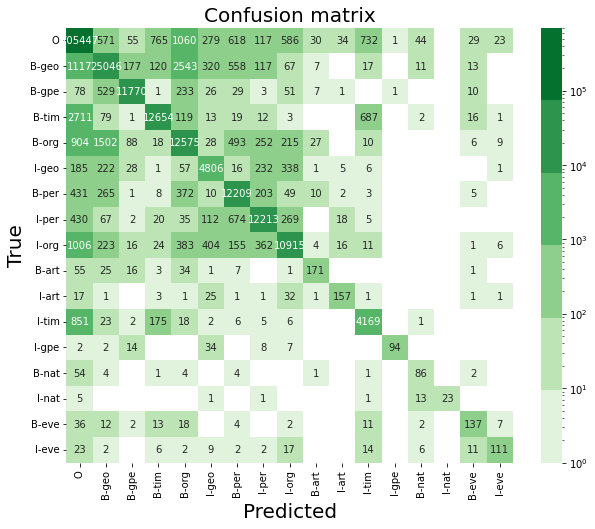

F1-Score: 0.97


In [9]:
eval_train = evaluate_corpus(train_seq.seq_list, pred_train, corpus.tag_dict, metric = 'all', exclude_O_acc = True)

Make predictions of the test data for this model

In [10]:
pred_test = [sp1.viterbi_decode(test_seq1)[0] for test_seq1 in test_seq]

Evaluate results in test set

Note: Words with real tag "O" are not being used in the computation of accuracy.
Accuracy: 26.009999999999998%
Precisions by tag:
Tag O: 99.3%
Tag B-geo: 19.78%
Tag B-gpe: 22.45%
Tag B-tim: 22.16%
Tag B-org: 20.46%
Tag I-geo: 19.34%
Tag B-per: 37.78%
Tag I-per: 50.88%
Tag I-org: 18.77%
Tag B-art: 7.89%
Tag I-art: 27.6%
Tag I-tim: 31.119999999999997%
Tag I-gpe: 9.93%
Tag B-nat: 11.43%
Tag I-nat: 9.520000000000001%
Tag B-eve: 30.45%
Tag I-eve: 15.229999999999999%
Confusion matrix:


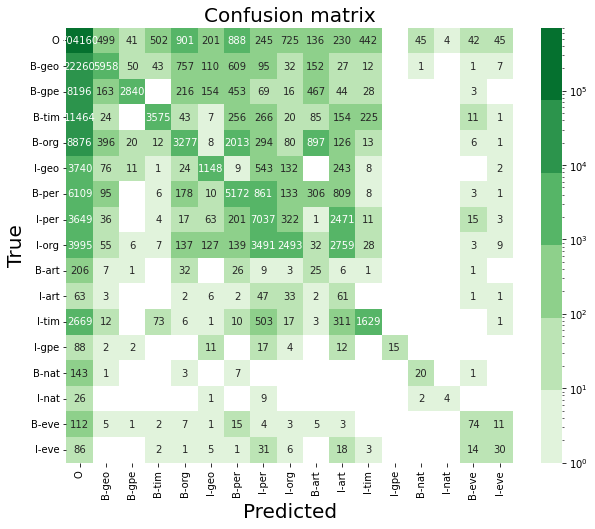

F1-Score: 0.86


'Metrics computed!'

In [11]:
evaluate_corpus(test_seq_real, pred_test, corpus.tag_dict, metric = 'all', exclude_O_acc = True)

Make predictions for tiny test data

In [12]:
pred_tiny = [sp1.viterbi_decode(tiny_seq1)[0] for tiny_seq1 in tiny_seq]

Show accuracy for these data:

In [14]:
evaluate_corpus(tiny_seq_real, pred_tiny, corpus.tag_dict, metric = 'accuracy', exclude_O_acc = 'True')

Note: Words with real tag "O" are not being used in the computation of accuracy.
Accuracy: 61.760000000000005%


'Metrics computed!'

We get an accuracy of 61.76\% considering the tags different to "O".

We show the predictions for the different sentences in tiny test for this model.

In [15]:
print('Model without adding features predictions')
for tiny_seq1 in tiny_seq:
    print(sp1.viterbi_decode(tiny_seq1)[0].to_words(train_seq, only_tag_translation=True))
    print('\n')


Model without adding features predictions
The/O programmers/O from/O Barcelona/B-geo might/O write/O a/O sentence/O without/O a/O spell/O checker/O ./O 


The/O programmers/O from/O Barchelona/O cannot/O write/O a/O sentence/O without/O a/O spell/O checker/O ./O 


Jack/B-per London/B-geo went/O to/O Parris/O ./O 


Jack/B-per London/B-geo went/O to/O Paris/B-geo ./O 


Bill/B-per gates/I-per and/O Steve/B-per jobs/O never/O thought/O Microsoft/B-org would/O become/O such/O a/O big/O company/O ./O 


Bill/B-per Gates/I-per and/O Steve/B-per Jobs/I-per never/O thought/O Microsoft/B-org would/O become/O such/O a/O big/O company/O ./O 


The/O president/O of/O U.S.A/O thought/O they/O could/O win/O the/O war/O ./O 


The/O president/O of/O the/O United/B-org States/I-org of/I-org America/I-org thought/O they/O could/O win/O the/O war/O ./O 


The/O king/O of/O Saudi/B-geo Arabia/I-geo wanted/O total/O control/O ./O 


Robin/O does/O not/O want/O to/O go/O to/O Saudi/B-geo Arabia/I-geo ./O

As we can see, it has some problems tagging new words or misspelled ones.

### Predictions model adding features

Make predictions of the train data for this model

In [11]:
pred_train = sp2.viterbi_decode_corpus(train_seq)

We evaluate the predictions through the function evaluate_corpus generated in utils.py

Note: Words with real tag "O" are not being used in the computation of accuracy.
Accuracy: 83.78%
Precisions by tag:
Tag O: 98.4%
Tag B-geo: 78.45%
Tag B-gpe: 93.13%
Tag B-tim: 82.04%
Tag B-org: 81.99%
Tag I-geo: 85.77%
Tag B-per: 91.47%
Tag I-per: 88.67%
Tag I-org: 80.28%
Tag B-art: 57.32000000000001%
Tag I-art: 65.7%
Tag I-tim: 83.99%
Tag I-gpe: 56.52%
Tag B-nat: 50.32%
Tag I-nat: 43.18%
Tag B-eve: 52.459999999999994%
Tag I-eve: 50.239999999999995%
Confusion matrix:


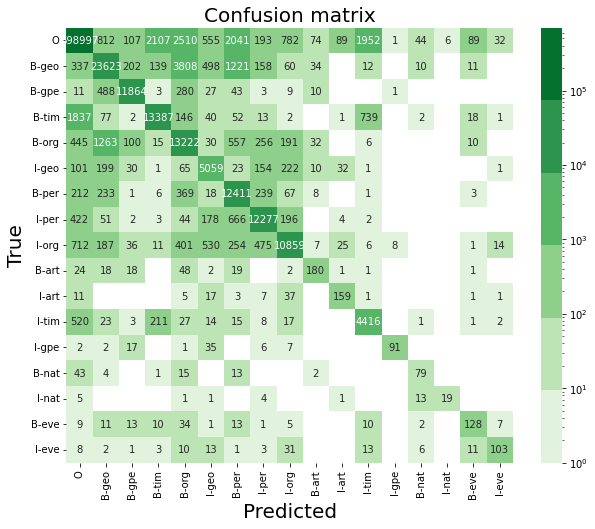

F1-Score: 0.96


In [12]:
eval_train = evaluate_corpus(train_seq.seq_list, pred_train, corpus.tag_dict, metric = 'all', exclude_O_acc = True)

Make predictions of the test data for this model

In [13]:
pred_test = [sp2.viterbi_decode(test_seq1)[0] for test_seq1 in test_seq]

Evaluate results in test set

Note: Words with real tag "O" are not being used in the computation of accuracy.
Accuracy: 45.989999999999995%
Precisions by tag:
Tag O: 98.03%
Tag B-geo: 35.67%
Tag B-gpe: 48.29%
Tag B-tim: 39.01%
Tag B-org: 45.71%
Tag I-geo: 38.87%
Tag B-per: 69.35%
Tag I-per: 68.17999999999999%
Tag I-org: 41.089999999999996%
Tag B-art: 8.52%
Tag I-art: 19.91%
Tag I-tim: 30.7%
Tag I-gpe: 9.93%
Tag B-nat: 10.86%
Tag I-nat: 7.140000000000001%
Tag B-eve: 30.04%
Tag I-eve: 15.229999999999999%
Confusion matrix:


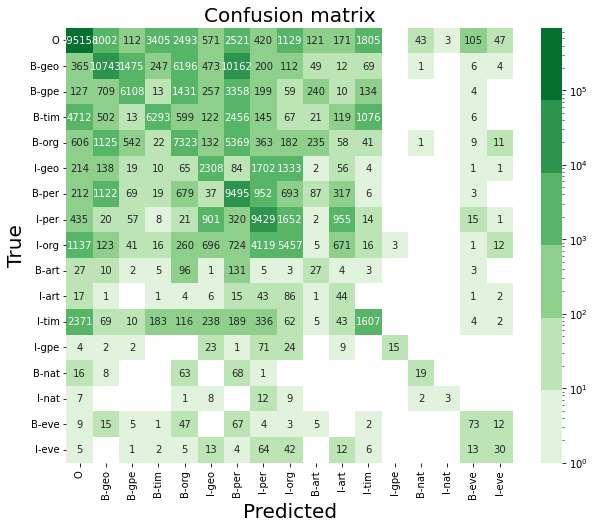

F1-Score: 0.9


'Metrics computed!'

In [14]:
evaluate_corpus(test_seq_real, pred_test, corpus.tag_dict, metric = 'all', exclude_O_acc = True)

Make predictions for tiny test data

In [8]:
pred_tiny = [sp2.viterbi_decode(tiny_seq1)[0] for tiny_seq1 in tiny_seq]

Show accuracy for these data:

In [9]:
evaluate_corpus(tiny_seq_real, pred_tiny, corpus.tag_dict, metric = 'accuracy', exclude_O_acc = 'True')

Note: Words with real tag "O" are not being used in the computation of accuracy.
Accuracy: 82.35%


'Metrics computed!'

We get an accuracy of 82.35\% considering the tags different to "O".

We show the predictions for the different sentences in tiny test for this model.

In [10]:
print('Model without adding features predictions')
for tiny_seq1 in tiny_seq:
    print(sp2.viterbi_decode(tiny_seq1)[0].to_words(train_seq, only_tag_translation=True))
    print('\n')


Model without adding features predictions
The/O programmers/O from/O Barcelona/B-org might/O write/O a/O sentence/O without/O a/O spell/O checker/O ./O 


The/O programmers/O from/O Barchelona/B-org cannot/O write/O a/O sentence/O without/O a/O spell/O checker/O ./O 


Jack/B-per London/I-per went/O to/O Parris/B-per ./O 


Jack/B-per London/I-per went/O to/O Paris/B-geo ./O 


Bill/B-per gates/O and/O Steve/B-per jobs/O never/O thought/O Microsoft/B-org would/O become/O such/O a/O big/O company/O ./O 


Bill/B-per Gates/I-per and/O Steve/B-per Jobs/I-per never/O thought/O Microsoft/B-org would/O become/O such/O a/O big/O company/O ./O 


The/O president/O of/O U.S.A/B-org thought/O they/O could/O win/O the/O war/O ./O 


The/O president/O of/O the/O United/B-geo States/I-geo of/I-geo America/I-geo thought/O they/O could/O win/O the/O war/O ./O 


The/O king/O of/O Saudi/B-geo Arabia/I-geo wanted/O total/O control/O ./O 


Robin/B-per does/O not/O want/O to/O go/O to/O Saudi/B-geo Arab

As we can see, it has some problems tagging new words or misspelled ones.

Finally we show the features that are activated for a sample sentence using the added features.

In [42]:
feature_type = ["Initial features", "Transition features", "Final features", "Emission features"]
inv_feature_dict = {word: pos for pos, word in feature_mapper.feature_dict.items()}
for feat,feat_ids in enumerate(feature_mapper.get_sequence_features(train_seq[29])):
    print(feature_type[feat])
    for id_list in feat_ids:
        print ("\t",id_list)
        for k,id_val in enumerate(id_list):
            print ("\t\t", inv_feature_dict[id_val] )
    print("\n")

Initial features
	 [0]
		 init_tag:O


Transition features
	 [4]
		 prev_tag:O::O
	 [101]
		 prev_tag:O::B-per
	 [104]
		 prev_tag:B-per::I-per
	 [106]
		 prev_tag:I-per::O
	 [4]
		 prev_tag:O::O
	 [4]
		 prev_tag:O::O
	 [4]
		 prev_tag:O::O
	 [4]
		 prev_tag:O::O
	 [4]
		 prev_tag:O::O
	 [4]
		 prev_tag:O::O
	 [4]
		 prev_tag:O::O
	 [4]
		 prev_tag:O::O
	 [4]
		 prev_tag:O::O


Final features
	 [38]
		 final_prev_tag:O


Emission features
	 [482, 2]
		 id:Prime::O
		 start_upper::O
	 [205, 2]
		 id:Minister::O
		 start_upper::O
	 [483, 99]
		 id:Geir::B-per
		 start_upper::B-per
	 [484, 103]
		 id:Haarde::I-per
		 start_upper::I-per
	 [159]
		 id:has::O
	 [485]
		 id:refused::O
	 [14]
		 id:to::O
	 [486]
		 id:resign::O
	 [411]
		 id:or::O
	 [487]
		 id:call::O
	 [292]
		 id:for::O
	 [368]
		 id:early::O
	 [488, 489]
		 id:elections::O
		 early::O
	 [36, 37]
		 id:.::O
		 dot::O


